# Basics

- Basic Concepts and Terms
    - algorithm
        - policy iteration
            - policy gradient
        - value iteration
            - sarsa： state, action, reward, state, action
                - Q-table：Table to learn (learning/iteration update)
                    - row index: state; column index: action;
                    - Not a probability distribution, but a value
            - q-learning
                - q-learning base q-table
                    - State must be/processed as discrete (discrete)
                    - q-table: Rows are states, columns are actions;
                    - $Q(s,a)$: Action value (value), not a probability distribution;
                        - $Q(s_t,a_t)$: The discounted total reward obtained by taking action $a_t$ in state $s_t$ at time $t$
                            - Future value discounted to the present;
                    - Image (pixels) as state, the number of state variables is extremely large;
            - q-learning => DQN (Deep Q Learning network)
                - DQN: nn(state) => action value,
                    - q table => q function (fitting/regression, relationship between state vector and action value) 
                    - Input/Output:
                        - Input: State vector
                            - CartPole: 4D vector (position, velocity, angle, and angular velocity), and even needs to care about their semantic meaning;
                        - Output: Action space value, $Q(s_t,a_t)$
                            - Shape: Size of action space;
                            - CartPole: 2D (left/right)
    - reward
        - The reward $R_t$ received at a specific time $t$ is called the immediate reward.
        - Future total reward $G_t$
            - $G_t=R_{t+1}+R_{t+2}+R_{t+3}+\cdots$
            - $G_t=R_{t+1}+\gamma R_{t+2}+\gamma^2R_{t+3} + \cdots + \gamma^kR_{t+k+1}\cdots$
        - Example
            - $Q_\pi(s=7,a=1)=R_{t+1}=1$
            - $Q_\pi(s=7,a=0)=\gamma^2$
    - action value，state value
    - bellman equation
        - Applies to the "state value function" and the "action value function"
    - mdp：markov decision process
        - Markov Property
            - $p(s_{t+1}|s_t)=p(s_{t+1}|{s_1,s_2,s_3,\cdots,s_t})$
        - Preconditions for the Bellman Equation to hold

## policy gradient
- $\theta$ with $\pi_{\theta}(s, a)$ (a function of $\theta$ (policy parameters) with respect to $s$ and $a$), finding $\pi_{\theta}$
    - $\theta$ is the policy parameter
    - $\pi_{\theta}(s, a)$ is the policy (parameterized by $\theta$)
    - $\pi$ represents a distribution
- Meaning of Policy Iteration (Policy Gradient)
    - $\theta_0 \rightarrow \pi_0$, $\theta_0 \rightarrow \theta_1$, $\theta_1 \rightarrow \pi_1$

- Based on softmax, a more general probabilistic approach
    - $$
    \mathbb P_{k} = \frac{\exp(z_k \cdot \beta)}{\sum_i \exp(z_i \cdot \beta)} \\
    = \frac{\exp(\frac{z_k} T)}{\sum_i \exp(\frac{z_i} T)} = \frac{\exp(\beta \cdot z_k)}{\sum_i \exp(\beta \cdot z_i)}
    $$
- update $\theta$ and $\pi_\theta$ base policy gradient
    - $\theta_{s_i, a_j} = \theta_{s_i, a_j} + \eta \Delta\theta_{s_i, a_j}$
    - $\Delta\theta_{s_i, a_j}=\frac{N(s_i, a_j)-P(s_i,a_j)\cdot N(s_i, a)}{T}$

- Policy Gradient => Deep Policy Gradient
    - Use deep networks to approximate $\pi_\theta(a_t|s_t)$
    - The output is a probability distribution, so add a softmax layer for probabilization.
- $$
\sum_{t}\nabla_\theta\log\pi_\theta(a_t|s_t)G_t
$$
- Note that the gradient update formula above maximizes the expected total reward, while neural networks minimize a target;
- $v_t = G_t = \sum_{k=0}^\infty \gamma^k R_{t+k+1}$
    - discounted **future** reward
    - The reward at the current action is estimated by discounting the future reward based on the current state;
- Policy Gradient Algorithm
    - Perform a trajectory/roll-out (MCTS) using the current policy (fixed $\pi_\theta(a_t|s_t)$ (represented by a neural network))
        - Trajectory: $\tau = (s_1, a_1, r_2, s_2, a_2, r_3, \ldots)$
            ```python
            s = env.reset()
            a, log_p = policy(s)
            next_state, reward, done, _ = env.step(a)
            if done:
                break
            s = next_state
            ```
        - Store the **log** probabilities (of the policy, $\log\pi_\theta(a_t|s_t)$) and reward values at each step
            - Probabilities are obtained through the policy network;
    - Calculate the **discounted cumulative future reward** ($G_t$) at each step
    - Compute the policy gradient ($\nabla J(\theta)$) and update the policy parameters (by gradient descent)
        - Backpropagation; the gradient update is performed by the neural network
        - Loss = $-\sum_{t} \log(\pi_{\theta}(a_t|s_t)) G_t$
        - `loss.backward()`
    - Repeat 1–3

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
from IPython.display import Image
import numpy as np

import gymnasium as gym
from mpmath.functions.elliptic import taufrom
from pygame.draw_py import draw_pixel
from sympy import false

env_name = 'CartPole-v1'

torch.cuda.is_available()

True

### policy network

In [37]:
class PolicyNetwork(nn.Module):
    def __init__(self, num_states, num_actions, hidden_size, learning_rate = 3e-4):
        super(PolicyNetwork, self).__init__()
        self.num_actions = num_actions
        self.policy_net = nn.Sequential(
            nn.Linear(num_states, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, num_actions),
            nn.Softmax(dim=1)
        )
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)
    def forward(self, x):
        # x.shape : (batch, num_states), batch: The number of steps in a complete trajectory
        # num_states of cartpole : env.observation_space.shape[0]
        #return: (batch, num_actions), with row sums equal to 1
        return self.policy_net(x)
    def choose_action(self, state):
        # state.shape (4,), 1d numpy ndarray
        # => 2d shape (1, 4)
        state = torch.from_numpy(state).type(torch.FloatTensor).unsqueeze(0)
        # probs,(1, 2)
        probs = self.forward(state)
        # Sample with probability
        action = np.random.choice(self.num_actions, p=np.squeeze(probs.detach().numpy()))
        # prob => log prob
        log_prob = torch.log(probs.squeeze(0)[action])
        # log_prob < 0
        return action, log_prob

### discounted future reward
$$
G_t=\sum_{k=0}^\infty \gamma^kR_{t+k+1}
$$

In [38]:
# rewards are generated by a single episode's trajectory
def discounted_future_rewards(rewards, gamma = 0.9):
    discounted_rewards = []
    for t in range(len(rewards)):
        G_t = 0
        k = 0
        for r in rewards[t:]:
            G_t += (gamma ** k) * r
            k += 1
        discounted_rewards.append(G_t)
    # len(discounted_rewards) == len(rewards)
    return discounted_rewards

### update policy

In [39]:
def update_policy(policy_network, rewards, log_probs):
    #len(rewards) == len(log_probs)
    #G_t
    discounted_rewards = discounted_future_rewards(rewards, gamma = 0.9)
    
    #nomalize discounted rewards => stability
    #one episode
    discounted_rewards = torch.tensor(discounted_rewards)
    discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + 1e-9)
    
    policy_grads = []
    for log_prob, G_t in zip(log_probs, discounted_rewards):
        policy_grads.append(-log_prob*G_t)
    loss = torch.stack(policy_grads).sum()
    
    policy_network.optimizer.zero_grad()
    loss.backward()
    policy_network.optimizer.step()

episode: 0, total reward: 12.0, avg reward: 12.0, length:11
episode: 100, total reward: 46.0, avg reward: 24.762376237623762, length:45
episode: 200, total reward: 20.0, avg reward: 27.54228855721393, length:19
episode: 300, total reward: 35.0, avg reward: 29.764119601328904, length:34
episode: 400, total reward: 74.0, avg reward: 34.32917705735661, length:73
episode: 500, total reward: 128.0, avg reward: 38.45309381237525, length:127
episode: 600, total reward: 33.0, avg reward: 44.47920133111481, length:32
episode: 700, total reward: 116.0, avg reward: 53.68758915834522, length:115
episode: 800, total reward: 130.0, avg reward: 64.64544319600499, length:129
episode: 900, total reward: 231.0, avg reward: 76.82907880133186, length:230
episode: 1000, total reward: 214.0, avg reward: 88.63236763236763, length:213
episode: 1100, total reward: 217.0, avg reward: 102.25068119891009, length:216
episode: 1200, total reward: 251.0, avg reward: 113.06577851790175, length:250
episode: 1300, tota

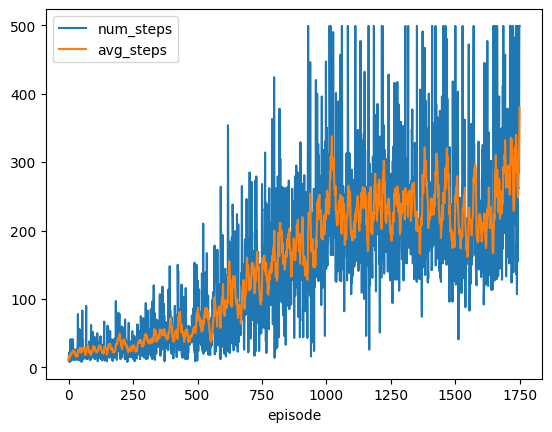

In [40]:
env = gym.make(env_name, render_mode="rgb_array")
policy_net = PolicyNetwork(env.observation_space.shape[0], env.action_space.n, 128)

max_episodes = 3000
max_steps = 500

num_steps = []
avg_num_steps = []
all_rewards = []
for episode in range(max_episodes):
    state = env.reset()[0]
    log_probs = []
    rewards = []
    for step in range(max_steps):
        # $\pi_\theta(a_t|s_t)$
        action, log_prob = policy_net.choose_action(state)
        next_state, reward, done, _, _ = env.step(action)
        
        log_probs.append(log_prob)
        rewards.append(reward)
        
        if done:
            break
        state = next_state
    # Complete one episode/rollout to obtain a complete trajectory
    num_steps.append(step)
    avg_num_steps.append(np.mean(num_steps[-10:]))
    update_policy(policy_net, rewards, log_probs)
    all_rewards.append(sum(rewards))
    if not done and avg_num_steps[-1]>=350:
        print(f'episode: {episode}, total reward: {sum(rewards)}, avg reward: {np.mean(all_rewards)}, length:{step}')
        break
    if episode % 100 == 0:
        print(f'episode: {episode}, total reward: {sum(rewards)}, avg reward: {np.mean(all_rewards)}, length:{step}')

import matplotlib.pyplot as plt

plt.plot(num_steps)
plt.plot(avg_num_steps)
plt.legend(['num_steps', 'avg_steps'])
plt.xlabel('episode')
plt.show()

In [41]:
print(num_steps[-10:])

[499, 154, 252, 280, 352, 480, 499, 285, 499, 499]


## value iteration
- Sarsa(state action reward state action)
- $R_t$
- $Q_{\pi}(s,a)$: state-action value function
    - Q-table
    - Iteratively update $Q_{\pi}(s,a)$ using the SARSA algorithm
- For reinforcement learning
    - State, action, and reward need to be carefully designed

- Sarsa (update $Q_\pi(s,a)$)
    - Ideally：
$$
Q(s_t,a_t) = R_{t+1}+\gamma Q(s_{t+1}, a_{t+1})
$$
  - td (temporal difference error)
    - $R_{t+1}+\gamma Q(s_{t+1},a_{t+1})-Q(s_t,a_t)$
  - final update equation
    - $Q(s_t,a_t)=Q(s_t,a_t)+\eta\cdot(R_{t+1}+\gamma Q(s_{t+1},a_{t+1})-Q(s_t,a_t))$
    - $s_t,a_t,r_{t+1},s_{t+1},a_{t+1}$
  - discount factor $\gamma$）
    - Reduces the number of steps (allows for faster task completion)

- q_learning
    - sarsa: $Q(s_t,a_t)=Q(s_t,a_t)+\eta\cdot(R_{t+1}+\gamma Q(s_{t+1},a_{t+1})-Q(s_t,a_t))$
    - Policy-on
    - q_learning: $Q(s_t,a_t)=Q(s_t,a_t)+\eta\cdot(R_{t+1}+\gamma \max_{a}Q(s_{t+1},a)-Q(s_t,a_t))$
    - Policy-off 
- DQN
    - $$
    \begin{split}
    &Q(s_t,a_t) = Q(s_t,a_t) + \eta\cdot (R_{t+1}+\gamma \max_a Q(s_{t+1},a)-Q(s_t,a_t))\\
    &Q(s_t,a_t) = R_{t+1}+\gamma\cdot \max_aQ(s_{t+1},a)
    \end{split}
    $$
    - iteration algorithm
        - temporal difference error（TD）: $R_{t+1}+\gamma\cdot \max_aQ(s_t,a) - Q(s_t,a_t)$
    - learning objective：
        - MES（square loss）: $E(s_t,a_t)=\left(R_{t+1}+\gamma\max_aQ(s_{t+1},a)-Q(s_t,a_t)\right)^2$
- Key Technologies
    - experience replay
      - Unlike q-learning with q-table, each step learns (updates) only the content of that step (experience)
        - For q-table, at each step, it learns the content of that step, and the neural network continuously learns high temporally correlated content
        - In reality, the content learned at time $t$ is very similar to the content learned at time $t+1$, which means convergence will be very slow
      - Instead, each step's content is stored in an experience pool, and random samples are extracted from the experience pool (replay) for the NN to learn
        - This is also a form of batching, using experiences from multiple steps in the experience pool
    - Loss function uses Huber loss instead of square loss
      - When the error is large ($|\delta| > 1$), square error will lead loss function's output being excessively large, making the learning process unstable
      - $$
        \mathcal L(\delta)=\begin{cases}
        \frac12\delta^2,  &\quad |\delta|\leq 1,\\
        |\delta|-\frac12, &\quad |\delta|\gt 1
        \end{cases}
        $$

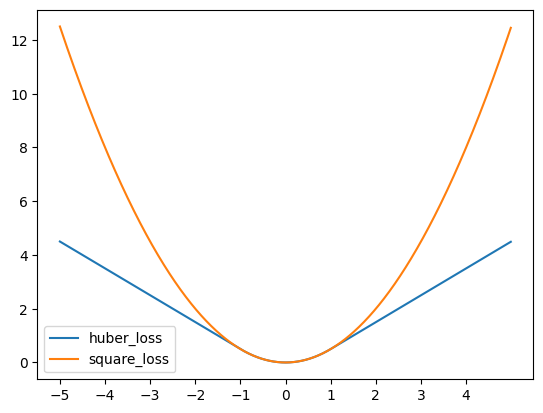

In [50]:
import matplotlib.pyplot as plt
import numpy as np

def huber_loss(delta,beta = 1):
    if np.abs(delta) > beta:
        return np.abs(delta)-0.5*beta
    else:
        return 0.5*delta**2/beta
    
def square_loss(delta):
    return 0.5*delta**2

deltas = np.arange(-5, 5, 0.01)
plt.plot(deltas, [huber_loss(delta) for delta in deltas])
plt.plot(deltas, square_loss(deltas))
plt.xticks(np.arange(-5, 5, step = 1))
plt.legend(['huber_loss', 'square_loss'])

### DQN
   - experience replay
     - Construct batch training data
     - Make the entire training process more stable
    

In [69]:
from collections import namedtuple,deque
from itertools import count
import random

In [70]:
# s_t, a_t => s_{t+1}
Transition = namedtuple('Transition', ('state','action','next_state','reward'))

In [74]:
class ReplayMemory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = deque([], maxlen=capacity)
    def push(self, state, action, next_state, reward):
        self.memory.append(Transition(state, action, next_state, reward))
        
    # list of transition
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    def __len__(self):
        return len(self.memory)

### DQN network

In [75]:
import torch
import math
import torch.nn as nn

device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

In [77]:
# Q_function base NN
class DQN(nn.Module):
    def __init__(self, n_states, n_actions):
        super(DQN, self).__init__()
        self.dqn = nn.Sequential(
            nn.Linear(n_states, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, n_actions)
        )
    
    def forward(self, x):
        # x.shape: batch_size * n_states
        # output.shape: batch_size * n_actions, state_action_value
        return self.dqn(x)

### Agent
   - Tensor shape changes and alignment during computation

In [78]:
class Agent:
    def __init__(self, n_states, n_actions, learning_rate = 1e-4, tau = 0.005,gamma = 0.99, capacity = 10000, batch_size = 128):
        self.n_states = n_states
        self.n_actions = n_actions
        self.tau = tau
        self.gamma = gamma
        self.batch_size = batch_size
        
        self.memory = ReplayMemory(capacity)
        self.policy_net = DQN(n_states, n_actions).to(device)
        self.target_net = DQN(n_states, n_actions).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.optimizer = optim.AdamW(self.policy_net.parameters(), lr=learning_rate, amsgrad=True)
        self.criterion = nn.SmoothL1Loss()
    
    def _optimize_model(self):
        if len(self.memory) < self.batch_size:
            return
        # list of transition
        batch = self.memory.sample(self.batch_size)
        #batch = [Transition(1, 2, 3, 4), Transition(5, 6, 7, 8)]
        #batch = Transition(*zip(*batch))
        #batch -> Transition(state=(1, 5), action=(2, 6), next_state=(3, 7), reward=(4, 8))
        # Transition, column: len(tuple) == batch_size
        batch = Transition(*zip(*batch))
        
        # s_t.shape: batch_size * 4
        state_batch = torch.cat(batch.state)
        # a_t.shape: batch_size * 1
        action_batch = torch.cat(batch.action)
        # r_{t+1}.shape: batch_size * 1
        reward_batch = torch.cat(batch.reward)
        
        # build model input and output (true)
        # s_t, input
        
        # pred: Q(s_t, a_t)
        # true: R_{t+1} + \gamma*\max_aQ(s_t,a)
        
        """
        [                       index               [[2, 1, 0]]         [[2, 1, 0]]
            [3, 4, 5],            ↓                 ↙    ↓   ↘           ↙   ↓   ↘
                 (0,2)      index of index       (0,0) (0,1) (0,2)   (0,0) (0,1) (0,2)
            [6, 7, 8],            ↓         ↙          dim=0               dim=1
              (1,1)         gather index         (2,0) (1,1) (0,2)   (0,2) (0,1) (0,0)
            [9, 10, 11]           ↓                ↓     ↓     ↓       ↓     ↓     ↓
           (2,0)                value            [[9,    7,    5]]   [[5,    4,    3]]
        ]
        """
        # pred, batch_size * 1
        state_action_values = self.policy_net(state_batch).gather(dim = 1, index = action_batch)
        
        # true: R_{t+1} + \gamma*\max_aQ(s_t, a)
        # tuple(map(lambda s: s is not None, batch.next_state)): batch_size 0/1
        # Compute a mask of non-final states and concatenate the batch elements
        # (a final state would've been the one after which simulation ended)
        non_final_mask = torch.tensor(tuple(map(lambda s:s is not None, batch.next_state)), device = device, dtype=torch.bool)
        # < batch_size
        non_final_next_state = torch.cat([s for s in batch.next_state if s is not None])
        next_state_values = torch.zeros(self.batch_size, device = device)
        # Q(s_{t+1}, a)
        with torch.no_grad():
            next_state_values[non_final_mask] = self.target_net(non_final_next_state).max(dim = 1)[0].detach()
        
        # (batch_size,)
        expected_state_action_values = reward_batch + self.gamma * next_state_values
        
        # unsqueeze(1) => (batch_size, 1)
        loss = self.criterion(state_action_values, expected_state_action_values.unsqueeze(1))
        
        self.optimizer.zero_grad()
        loss.backward()
        # In-place gradient clipping
        nn.utils.clip_grad_value_(self.policy_net.parameters(), 100)
        self.optimizer.step()
        
        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = self.target_net.state_dict()
        policy_net_state_dict = self.policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key] * self.tau + target_net_state_dict[key] * (1 - self.tau)
        self.target_net.load_state_dict(target_net_state_dict)
    
    def update_q_function(self):
        self._optimize_model()
    
    def memorize(self, state, action, next_state, reward):
        self.memory.push(state, action ,next_state, reward)
    
    # action policy
    # epsilon_greedy
    # double e: explore, exploit
    def choose_action(self, state, steps_done, eps_decay = 1000):
        #The probability of choosing a random action will start at EPS_START=0.9 and will decay exponentially towards EPS_END=0.05. EPS_DECAY=1000 controls the rate of the decay.
        eps = 0.05 + (0.9-0.05)*math.exp(-1.*steps_done/eps_decay)
        if random.random() > eps:
            with torch.no_grad():
                # .max(1) will return the largest column value of each row.
                # second column on max result is index of where max element was
                # found, so we pick action with the larger expected reward.
                action = self.policy_net(state).max(1)[1].view(1, 1)
        else:
            # explore
            action = torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)
        
        return action

### Agent interacts with the environment

In [79]:
env_name = 'CartPole-v1'

env= gym.make(env_name, render_mode="rgb_array")
n_states = env.observation_space.shape[0]
n_actions = env.action_space.n

max_episodes = 500

complete_episodes = 0
finished_flag = False

agent = Agent(n_states, n_actions)
steps_done = 0
frames = []
all_steps = []

for episode in range(max_episodes):
    state, _= env.reset()
    # (4,)
    # (4,) => (1, 4) for torch.cat=> (1, 4) => (32, 4)
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for step in count():
        if finished_flag:
            frames.append(env.render())
        # IntTensor 1*1
        steps_done += 1
        action = agent.choose_action(state, steps_done)
        
        #transition on env
        next_state, reward, terminated, truncated, _ = env.step(action.item())
        
        if terminated and not truncated:
            complete_episodes = 0
        if truncated:
            complete_episodes +=1
        reward = torch.tensor([reward], device=device)
        # terminated = true, when the agent reaches a terminal state or exceeds the maximum number of steps
        # truncated = true, when maximum episode steps being reached, but not because of a terminal state
        done = terminated or truncated
        
        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0)
        
        agent.memorize(state, action, next_state, reward)
        agent.update_q_function()
        state = next_state
        
        if done:
            all_steps.append(step+1)
            print(f'episode: {episode}, steps:{step}')
            break
    
    if finished_flag:
        break
            
    if complete_episodes >= 10:
        finished_flag = True
        print("continuous complete 10 episodes")

episode: 0, steps:19
episode: 1, steps:12
episode: 2, steps:17
episode: 3, steps:22
episode: 4, steps:14
episode: 5, steps:12
episode: 6, steps:23
episode: 7, steps:11
episode: 8, steps:65
episode: 9, steps:11
episode: 10, steps:12
episode: 11, steps:10
episode: 12, steps:53
episode: 13, steps:35
episode: 14, steps:36
episode: 15, steps:8
episode: 16, steps:33
episode: 17, steps:11
episode: 18, steps:12
episode: 19, steps:11
episode: 20, steps:11
episode: 21, steps:18
episode: 22, steps:14
episode: 23, steps:27
episode: 24, steps:17
episode: 25, steps:8
episode: 26, steps:11
episode: 27, steps:9
episode: 28, steps:8
episode: 29, steps:10
episode: 30, steps:12
episode: 31, steps:13
episode: 32, steps:12
episode: 33, steps:13
episode: 34, steps:13
episode: 35, steps:11
episode: 36, steps:11
episode: 37, steps:8
episode: 38, steps:9
episode: 39, steps:10
episode: 40, steps:7
episode: 41, steps:12
episode: 42, steps:8
episode: 43, steps:11
episode: 44, steps:17
episode: 45, steps:16
episod

### visualization

In [80]:
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from matplotlib import animation

output = 'cartpole.gif'

In [81]:
def display_frames_as_gif(frames, output):
    # Displays a list of frame as a gif,with controls
    
    fig = plt.figure(figsize = (frames[0].shape[1]/72.0, frames[0].shape[0]/72.0), dpi = 72)
    patch = plt.imshow(frames[0])
    plt.axis('off')
    
    def animate(i):
        img = patch.set_data(frames[i])
        return img # must return
    
    anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval=50)
    
    anim.save(output)
    return HTML(anim.to_jshtml())

In [82]:
display_frames_as_gif(frames, output)

In [86]:
def plot_durations(episode_durations, show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if not show_result:
        display(plt.gcf())
        display.clear_output(wait=True)
    else:
        display(plt.gcf())

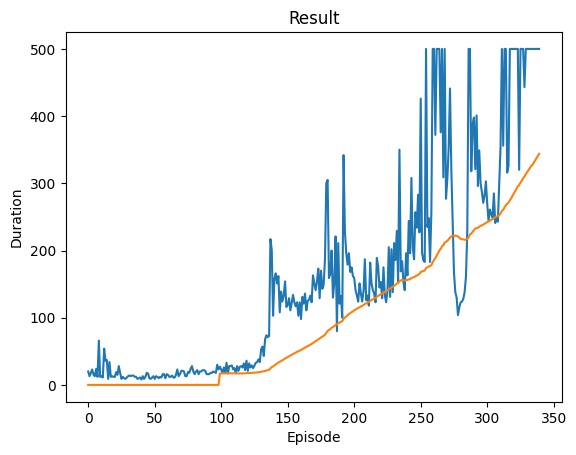

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [89]:
plot_durations(all_steps, show_result=True)
plt.ioff()
plt.show()